In [63]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.ion()   # interactive mode

In [2]:
from torchsummary import summary

## 1. Loading data


In [3]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1 , saturation = 0.1), #random brightness, contrast etc
        transforms.GaussianBlur(kernel_size=(15, 15)),
        transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3), #random brightness, contrast etc
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = './sg_food' 
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


In [5]:
device

device(type='cpu')

## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



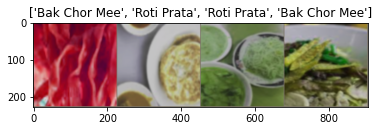

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Model Initailization

### 3.1 Define Models

In [7]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/pineapple/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/pineapple/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/pineapple/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100.0%


### 3.2 Modify Models

In [8]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

In [9]:
# Summary

# VGG16
summary(vgg16.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [10]:
# ResNet18
summary(resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
# Inception_v3
summary(inception_v3.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### 3.3 Dict for Models

In [12]:
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    "Inception_v3": inception_v3
}

## 4. Training

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if is_inception and phase == 'train':
                    inputs = torch.stack([F.resize(input, size=(299, 299)) for input in inputs])

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.detch().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [14]:
def visualize_training(val_acc_history):
    plt.figure()
    # 确保将 tensor 转移到 CPU
    val_acc_history_cpu = [h.cpu() for h in val_acc_history]
    plt.plot(val_acc_history_cpu)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Training History")
    plt.show()


In [15]:
# Loop through each model for training
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define Criterion
    criterion = nn.CrossEntropyLoss()
    
    # Define Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Inception_v3
    is_inception = (model_name == "Inception_v3")
    
    trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=is_inception)
    
    # Visualize Training Result
    visualize_training(val_acc_history)
    
    # Save Checkpoints
    torch.save(trained_model.state_dict(), f"./model/{model_name}_model.pth")

Training VGG16...
Epoch 1/25
----------


KeyboardInterrupt: 

**Train Swin Transformer (tiny) with lr scheduler**

In [ ]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.head)
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
model = model.to(device)
print(model.head)

In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [ ]:
trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    
# Visualize Training Result
visualize_training(val_acc_history)
    
# Save Checkpoints
torch.save(trained_model.state_dict(), f"/kaggle/working/swin_tiny.pth")

# 5. Prediction and Evaluation

In [ ]:
# Load the pre-trained Swin_tiny model
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
swin_tiny = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

In [ ]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

# Modify Swin_tiny
swin_tiny.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

In [ ]:
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    "Inception_v3": inception_v3,
    "SwinTransformer_tiny": swin_tiny
}

In [ ]:
# Data normalization for testing
test_data_transform = transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ])

data_dir = '/kaggle/input/sg-food/sg_food' 

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
test_image_dataset = sg_food_dataset(root=os.path.join(data_dir, 'test'),
                                     class_id=selected_classes,
                                     transform=test_data_transform) 
class_names = test_image_dataset.classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)

test_dataset_size = len(test_image_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
best_model_paths = {
    #"VGG16": "/kaggle/input/VGG16/pytorch/v1/1/VGG16_model.pth",
    "ResNet18": "/kaggle/input/resnet18-v1/pytorch/v1/1/ResNet18_model.pth",
    "Inception_v3": "/kaggle/input/inception_v3/pytorch/v1/1/Inception_v3_model.pth",
    "SwinTransformer_tiny": "/kaggle/input/swin_tiny/pytorch/v1/1/swin_tiny.pth"
}

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(model,test_dataloader,class_names):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):   
                label = labels[i]
                #for confusion matrix
                y_true.append(label.to('cpu'))
                y_pred.append(predicted[i].to('cpu'))
                
        
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["BCM","CR","KTE","OO","RP"])
    disp.plot()
    plt.title("confusion matrix")
    plt.show()
    
    

In [ ]:
for model_name, model in models_dict.items():
    if model_name == "VGG16":
        continue
    print(f"Testing {model_name}...")
    
    model.to(device)
    model.load_state_dict(torch.load(best_model_paths[model_name]))
    model.eval()
    evaluate(model,test_dataloader,class_names)
    

### advanced 1

### Threshold

In [36]:
# Load ResNet18
model = models.resnet18(pretrained=False)

# Modify Model, Remove FC Layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)

# Load pretrained weight
model.load_state_dict(torch.load("./model/ResNet18_model.pth", map_location=torch.device('cpu')),strict = False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
def predict_with_confidence(model, image_tensor, threshold=0.5):
    with torch.no_grad():  # 不计算梯度
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, preds = torch.max(probabilities, 1)
        if max_prob.item() < threshold:
            return 'Unknown'
        else:
            return f'Class {preds.item()} with confidence {max_prob.item()}'

In [38]:
val_transforms = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # 确保转换为RGB
    return val_transforms(image).unsqueeze(0)  # 添加批次维度，因为模型期待批次作为第一维度



In [44]:
# 假设你已经有了一个图像路径
image_path = '/Users/pineapple/Desktop/4414/IE4414_F34_Grp7/sg_food/train/Hokkien Prawn Mee/Hokkien Prawn Mee(57).jpg'
image_tensor = preprocess_image(image_path)

In [45]:

prediction = predict_with_confidence(model, image_tensor, threshold=0.7)
print(prediction)

Class 0 with confidence 0.9117933511734009


### SVM

In [49]:
class sg_food_dataset(torch.utils.data.Dataset):
    def __init__(self, root, class_id, transform=None, include_others=False):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {root}.")

        self.classes = [all_classes[x] for x in class_id] + (['others'] if include_others else [])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        others_index = self.class_to_idx.get('others', len(self.classes))  # 默认为最后一个索引
        
        self.samples = []
        for entry in os.scandir(root):
            if entry.is_dir():
                dir_index = self.class_to_idx.get(entry.name, others_index)
                for img_entry in os.scandir(entry.path):
                    if img_entry.name.endswith(('jpg', 'jpeg', 'png')) and (dir_index != others_index or include_others):
                        self.samples.append((img_entry.path, dir_index))

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [50]:
data_dir = './sg_food' 
subfolder = {'train': 'train', 'val': 'val'}
selected_classes = [0, 2, 4, 7, 9]  # 选定的5个类别

# Define the dataset with the others category included
image_datasets = {
    x: sg_food_dataset(
        root=os.path.join(data_dir, subfolder[x]),
        class_id=selected_classes,
        transform=data_transforms[x],
        include_others=True if x == 'train' else False  # 只在训练集中包括 'others' 类别
    ) for x in ['train', 'val']
}

# 数据加载器
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=0)
    for x in ['train', 'val']
}

class_names = image_datasets['train'].classes
print('Selected classes with "others":', class_names)


Selected classes with "others": ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata', 'others']


In [52]:
# 加载预训练的ResNet18模型
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Identity()  # 将全连接层替换为Identity以输出特征

# 加载你自己的权重
model.load_state_dict(torch.load("./model/ResNet18_model.pth", map_location=torch.device('cpu')), strict=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
def get_features_and_labels(dataloader):
    features = []
    labels = []
    for inputs, label in dataloader:
        with torch.no_grad():
            outputs = model(inputs)
        features.extend(outputs.detach().cpu().numpy())
        labels.extend(label.detach().cpu().numpy())
    return features, labels

In [54]:
train_features, train_labels = get_features_and_labels(dataloaders['train'])
val_features, val_labels = get_features_and_labels(dataloaders['val'])

In [71]:

# 定义类权重
weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.142}  # 假设类5是“others”类

# 创建一个管道，包括标准化和带权重的SVC
pipeline = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', probability=True, class_weight=weights))

# 定义参数网格
param_grid = {'svc__C': [0.01, 0.1, 1]}

# 使用 GridSearchCV 来搜索最佳参数
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# 训练模型
grid_search.fit(train_features, train_labels)

# 打印最佳参数和对应的性能评分
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))




Best parameters: {'svc__C': 1}
Best cross-validation score: 0.54


Validation Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        30
           1       0.88      0.50      0.64        30
           2       0.77      0.77      0.77        30
           3       0.85      0.57      0.68        30
           4       0.75      0.90      0.82        30
           5       0.00      0.00      0.00         0

    accuracy                           0.65       150
   macro avg       0.66      0.54      0.59       150
weighted avg       0.80      0.65      0.70       150



/Users/pineapple/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pineapple/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pineapple/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

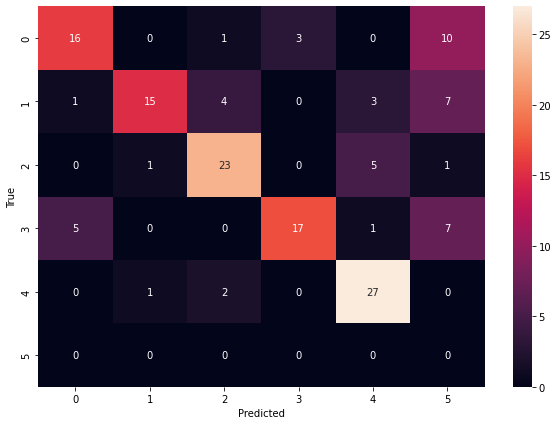

In [72]:
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sb


# 使用最佳模型对验证集进行预测
val_predictions = grid_search.best_estimator_.predict(val_features)

# 计算并打印准确率
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy: {:.2f}".format(val_accuracy))

# 打印详细的分类报告
print(classification_report(val_labels, val_predictions))

cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10,7))
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()